# `friedrich` results

In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11/chains???.hdf5'))
#archive_paths = sorted(glob('/local/tmp/friedrich/hat11_init/chains???.hdf5'))
print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris())
    all_times.extend(m.lc.times.jd)

#     # Convert samples into spot measurements
#     results = np.percentile(m.chains, [15.87, 50, 84.13], axis=0)

#     spots = []
#     for spot in np.split(results[:, 1:].T, (m.chains.shape[1]-1)/3):
#         ampltiude, t0, sigma = map(lambda x: Measurement(*(x[1], 
#                                                            x[2]-x[1], 
#                                                            x[1]-x[0])), 
#                                    spot)
#         spots.append(Spot(ampltiude, t0, sigma)) 
    spots = m.get_spots()
    transits.append(Transit(spots))

load results


In [148]:
transit_params.rp

0.058330305324663184

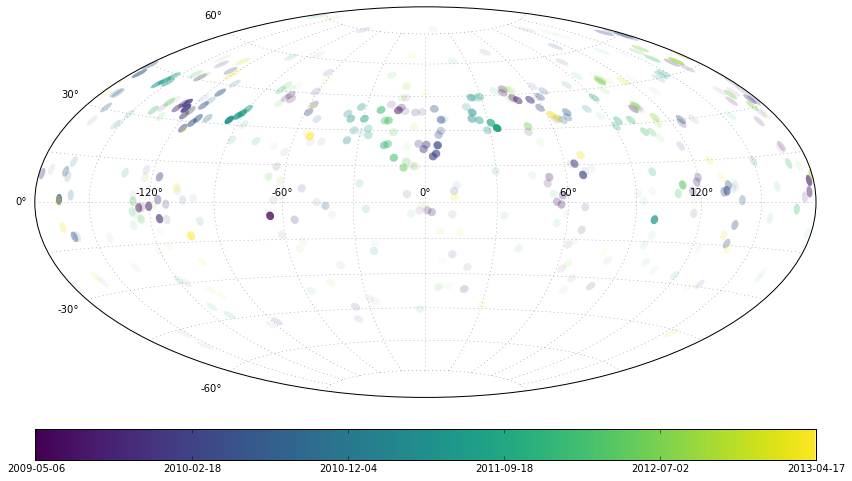

In [150]:
from friedrich.orientation import times_to_occulted_lat_lon
from friedrich.lightcurve import hat11_params_morris
from astroML.plotting import plot_tissot_ellipse

transit_params = hat11_params_morris()
projection = 'Hammer'

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())#, axisbg='black')
ax2 = plt.subplot(212)#, axisbg='black')

def custom_grid(ax, color='gray'):
    # plot latitude/longitude grid
    ax.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3
                                                * np.linspace(-2, 2, 5)))
    ax.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6
                                                * np.linspace(-5, 5, 11)))
    ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6
                                                * np.linspace(-2, 2, 5)))
    ax.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12
                                                * np.linspace(-5, 5, 11)))

    ax.grid(True, which='minor', color=color, ls=':')
    
    if color != 'gray':
        for l in ax.get_xticklabels():
            l.set_color(color)

custom_grid(ax)

# all_spot_times = np.array([spot.t0.value for spot in transit.spots 
#                            for transit in transits])
all_spot_times = np.array([spot.t0.value for transit in transits
                           for spot in transit.spots])
def tcolorscale(t):
    color = (t - all_spot_times.min())/(all_spot_times.max() - all_spot_times.min())
    return color

def sigma_prior(sigma):
    # Should less than 20 min, greater than 1
    if sigma*24*60 > 15 or sigma*24*60 < 2: 
        return 1e4
    else:
        return 1

radius = 1.0*np.tan(transit_params.rp)  # from s=r*theta

cmap = plt.cm.viridis
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        alpha = spot.amplitude.value*500/sigma_prior(spot.sigma.value)
        #alpha = 0.5/sigma_prior(spot.sigma.value)
        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, linewidth=0,
                            alpha = alpha if alpha < 1 else 1,
                            color=cmap(tcolorscale(spot.t0.value)))

from matplotlib.ticker import FuncFormatter
from astropy.time import Time
       
def plot_color_gradients(fig, ax):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack(10*[gradient])

    ax.imshow(gradient, cmap=plt.get_cmap('viridis'), aspect=1.0) 
    ax.set_yticks([])
    nticks = 6
    datespace = np.linspace(all_spot_times.min(), all_spot_times.max(), nticks)
    axspace = np.linspace(0, 256, nticks)
    xtickdates = [t.date() for t in Time(datespace, format='jd').datetime]
    ax.set_xticks(axspace)
    ax.set_xticklabels(xtickdates)

plot_color_gradients(fig, ax2)
fig.subplots_adjust(hspace=-0.55)

In [3]:
all_lats = []
all_lons = []
all_amps = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
all_lats = np.array(all_lats)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

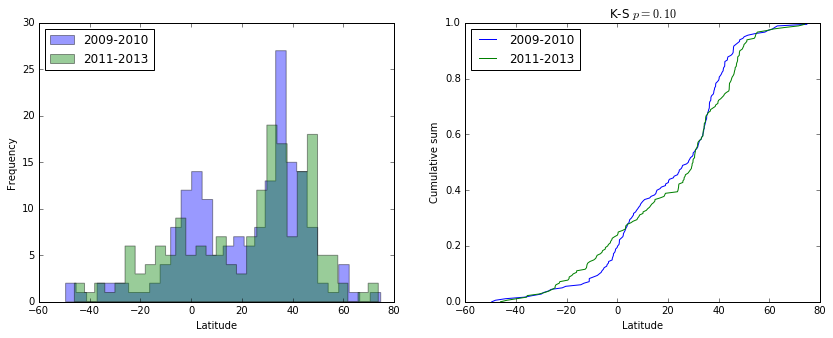

In [4]:
strong_lats = all_lats[all_BICs > 10]
strong_lats_times = all_spot_times[all_BICs > 10]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lats = strong_lats[:int(0.5*len(strong_lats))]
second_half_strong_lats = strong_lats[-len(first_half_strong_lats):]

nbins = 30
ax[0].hist(np.degrees(first_half_strong_lats), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4, label='2009-2010')
ax[0].hist(np.degrees(second_half_strong_lats), nbins, histtype='stepfilled', 
           facecolor='g', alpha=0.4, label='2011-2013')

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(first_half_strong_lats)), label='2009-2010')
ax[1].plot(*cumdist(np.degrees(second_half_strong_lats)), label='2011-2013')

from scipy.stats import ks_2samp
ks = ks_2samp(first_half_strong_lats.ravel(), second_half_strong_lats.ravel())

ax[0].legend(loc='upper left')
ax[0].set(xlabel='Latitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Latitude', ylabel='Cumulative sum', 
          title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

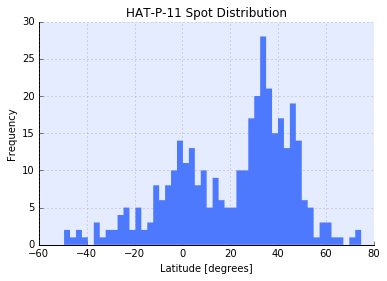

In [141]:
import seaborn as sns
#sns.set(style="dark")

fig, ax = plt.subplots()
ax.grid(color='gray')
ax.hist(np.degrees(strong_lats), 50, histtype='stepfilled', 
        zorder=100, color='#4d79ff', edgecolor='none')
ax.set_xlabel('Latitude [degrees]')

ax.spines['right'].set_color('none')
ax.yaxis.set_ticks_position('left')

ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylabel('Frequency')
ax.set_axis_bgcolor('#e6ecff')
ax.set_title('HAT-P-11 Spot Distribution')
plt.savefig('plots/latitudes.pdf', bbox_inches='tight')
plt.show()

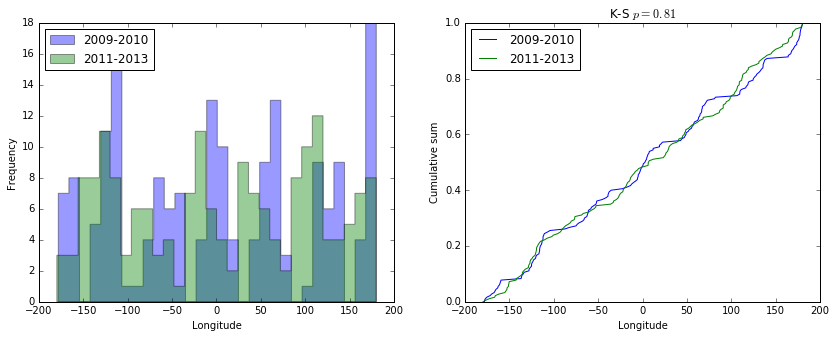

In [5]:
strong_lons = all_lons[all_BICs > 10]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lons = strong_lons[:int(0.5*len(strong_lons))]
second_half_strong_lons = strong_lons[-len(first_half_strong_lons):]

nbins = 30
ax[0].hist(np.degrees(first_half_strong_lons), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4, label='2009-2010')
ax[0].hist(np.degrees(second_half_strong_lons), nbins, histtype='stepfilled', 
           facecolor='g', alpha=0.4, label='2011-2013')

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(first_half_strong_lons)), label='2009-2010')
ax[1].plot(*cumdist(np.degrees(second_half_strong_lons)), label='2011-2013')

from scipy.stats import ks_2samp
ks = ks_2samp(first_half_strong_lons.ravel(), second_half_strong_lons.ravel())

ax[0].legend(loc='upper left')
ax[0].set(xlabel='Longitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Longitude', ylabel='Cumulative sum', 
          title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

In [6]:
import friedrich
import imp
imp.reload(friedrich)
import friedrich

from friedrich.orientation import times_to_occulted_lat_lon

lats = np.zeros(len(all_times))#[]
lons = np.zeros(len(all_times))#[]
for i, t in enumerate(all_times):
    lat, lon = times_to_occulted_lat_lon(np.array([t]), hat11_params_morris())
    lats[i] = lat
    lons[i] = lon

../friedrich/orientation.py:386: RuntimeWarning: invalid value encountered in sqrt
  projected_z = np.sqrt(1 - x**2 - y**2)


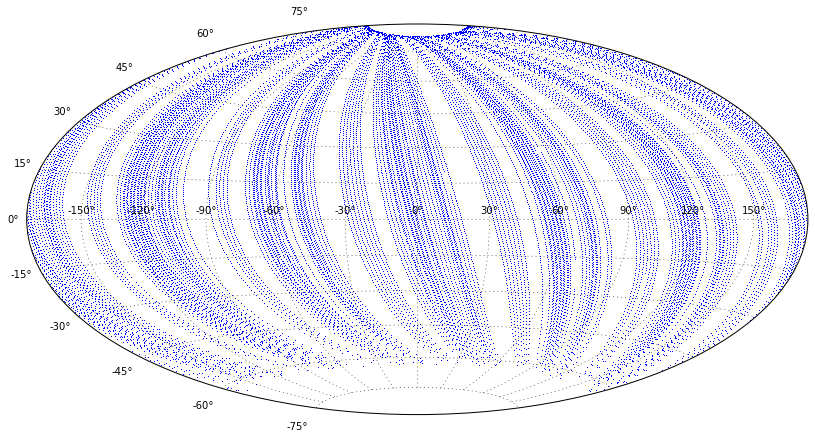

In [7]:
projection = 'Hammer'

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(111, projection=projection.lower())
ax.plot(lons, lats, ',')
ax.grid()

In [70]:
n_bins = 100
lon_grid = np.linspace(-np.pi, np.pi, n_bins)
lat_grid = np.linspace(-np.pi/2, np.pi/2, n_bins)

bins = np.zeros((n_bins, n_bins))
spots_in_visit_bin = np.zeros((n_bins, n_bins))
for i in range(n_bins-1):
    
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]

    visits_in_lon_bin = ((lons < lon_bin_upper) & 
                         (lons > lon_bin_lower))
    spots_in_lon_bin = ((strong_lons < lon_bin_upper) & 
                        (strong_lons > lon_bin_lower))
    
    for j in range(n_bins-1):
        
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]

        visits_in_lat_bin = ((lats < lat_bin_upper) & 
                      (lats > lat_bin_lower))
        
        bins[j, i] = np.count_nonzero(visits_in_lat_bin & 
                                      visits_in_lon_bin)

        spots_in_lat_bin = ((strong_lats < lat_bin_upper) & 
                            (strong_lats > lat_bin_lower))
        
        spots_in_visit_bin[j, i] = np.count_nonzero(spots_in_lon_bin &
                                              spots_in_lat_bin)
        
# plt.imshow(bins, interpolation='nearest', origin='lower')
# fig = plt.figure(figsize=(14, 14))
# ax = plt.subplot(111, projection=projection.lower())
# ax.plot(lon_grid, lat_grid, ',')
# ax.grid()

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less
/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


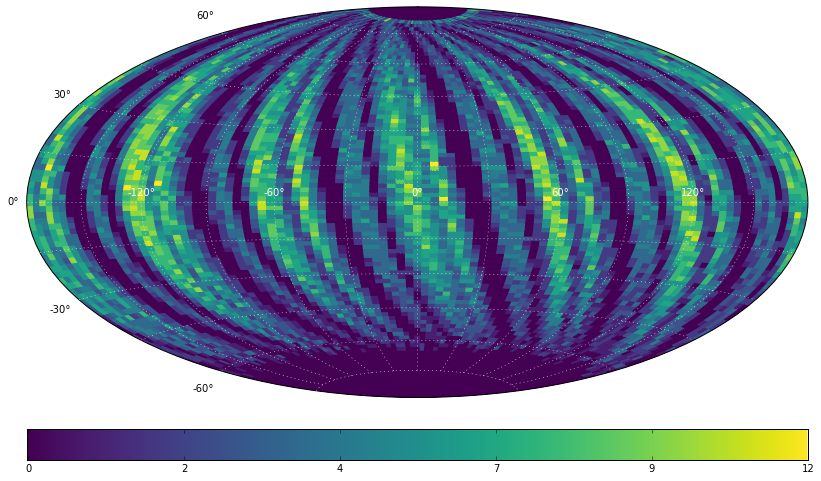

In [9]:
projection = 'Hammer'

cmap = plt.cm.viridis
def color_scale(x):
    return (x - bins.min()) / bins.max()

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())

for i in range(n_bins-1):
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]
    for j in range(n_bins-1):
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]
        
        # [lon min, lon max], [lat min, lat min], [lat max]
        ax.fill_between([lon_bin_lower, lon_bin_upper], 
                        [lat_bin_lower, lat_bin_lower], 
                        lat_bin_upper, 
                        color=cmap(color_scale(bins[j, i])))
        
def plot_colorbar(fig, ax):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack(10*[gradient])

    ax.imshow(gradient, cmap=plt.get_cmap('viridis'), aspect=1.0) 
    ax.set_yticks([])
    nticks = 6
    axspace = np.linspace(0, 256, nticks)
    xticks = np.linspace(bins.min(), bins.max(), nticks).astype(int)
    ax.set_xticks(axspace)
    ax.set_xticklabels(xticks)

custom_grid(ax, color='w')
ax2 = plt.subplot(212)
plot_colorbar(fig, ax2)
fig.subplots_adjust(hspace=-0.55)

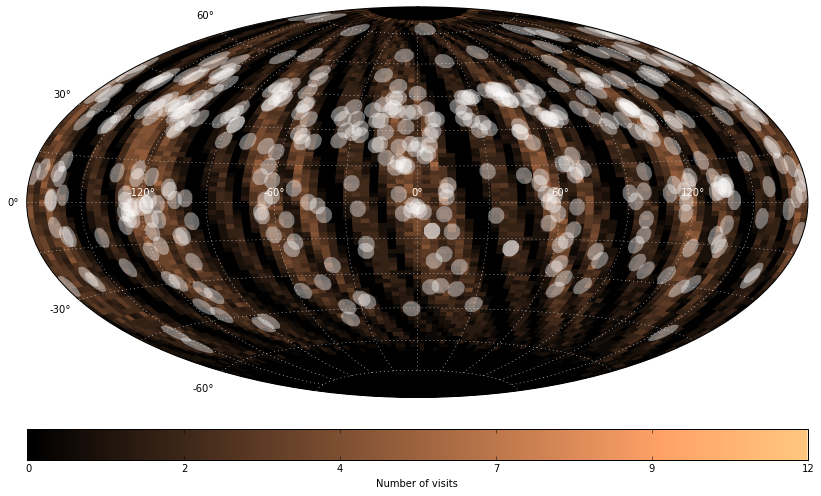

In [10]:
projection = 'Hammer'

cmap = plt.cm.copper #plt.cm.viridis
def color_scale(x):
    return (x - bins.min()) / 2 / bins.max()

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())

for i in range(n_bins-1):
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]
    for j in range(n_bins-1):
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]
        
        # [lon min, lon max], [lat min, lat min], [lat max]
        ax.fill_between([lon_bin_lower, lon_bin_upper], 
                        [lat_bin_lower, lat_bin_lower], 
                        lat_bin_upper, 
                        color=cmap(color_scale(bins[j, i])))
        
def plot_colorbar(fig, ax):
    gradient = np.linspace(0, 1/2, 256)
    gradient = np.vstack(10*[gradient])

    ax.imshow(gradient, cmap=cmap, aspect=1.0) 
    ax.set_yticks([])
    nticks = 6
    axspace = np.linspace(0, 256, nticks)
    xticks = np.linspace(bins.min(), bins.max(), nticks).astype(int)
    ax.set_xticks(axspace)
    ax.set_xticklabels(xticks)

ax2 = plt.subplot(212)
plot_colorbar(fig, ax2)
fig.subplots_adjust(hspace=-0.55)

# plot spots
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        #alpha = spot.amplitude.value*500/sigma_prior(spot.sigma.value)
        alpha = 0.4/sigma_prior(spot.sigma.value)
        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, linewidth=0,
                                alpha = alpha if alpha < 1 else 1,
                                color='w')
        
custom_grid(ax, color='w')
ax2.set_xlabel('Number of visits')

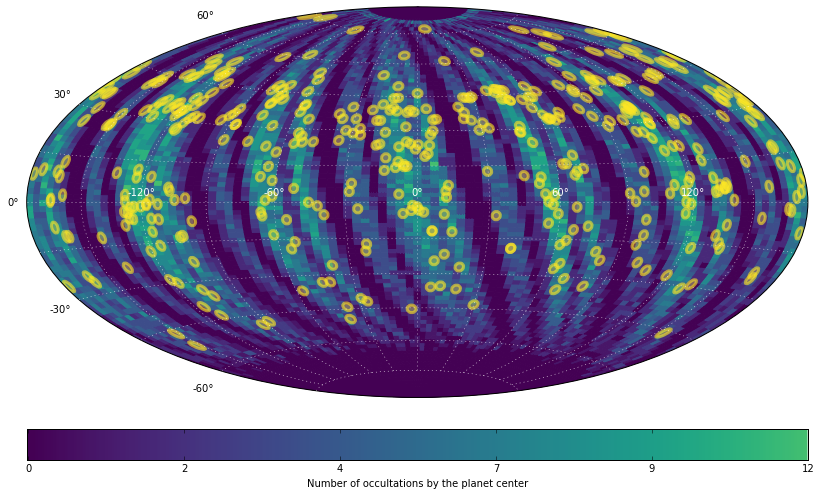

In [151]:
projection = 'Hammer'

cmap = plt.cm.viridis # plt.cm.copper
fraction_of_colorbar = 0.7
circle_color = plt.cm.viridis(1.0)

def color_scale(x):
    return fraction_of_colorbar*(x - bins.min()) / bins.max()
    #return (x - bins.min()) / 2 / bins.max()

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())

for i in range(n_bins-1):
    lon_bin_lower = lon_grid[i]
    lon_bin_upper = lon_grid[i+1]
    for j in range(n_bins-1):
        lat_bin_lower = lat_grid[j]
        lat_bin_upper = lat_grid[j+1]
        
        # [lon min, lon max], [lat min, lat min], [lat max]
        ax.fill_between([lon_bin_lower, lon_bin_upper], 
                        [lat_bin_lower, lat_bin_lower], 
                        lat_bin_upper, 
                        color=cmap(color_scale(bins[j, i])))
        
def plot_colorbar(fig, ax):
    gradient = np.linspace(0, fraction_of_colorbar, 256)
    gradient = np.vstack(10*[gradient])

    ax.imshow(gradient, cmap=cmap, aspect=1.0, vmin=0, vmax=1) 
    ax.set_yticks([])
    nticks = 6
    axspace = np.linspace(0, 256, nticks)
    xticks = np.linspace(bins.min(), bins.max(), nticks).astype(int)
    ax.set_xticks(axspace)
    ax.set_xticklabels(xticks)

ax2 = plt.subplot(212)
plot_colorbar(fig, ax2)
fig.subplots_adjust(hspace=-0.55)

# plot spots
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)

        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, facecolor='none', 
                                edgecolor=circle_color, lw=3, alpha=0.6)
        
        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, linewidth=0,
                                alpha=0.3, facecolor=circle_color)
        
custom_grid(ax, color='w')
ax2.set_xlabel('Number of occultations by the planet center')

In [152]:
fig.savefig('plots/map.pdf', bbox_inches='tight')

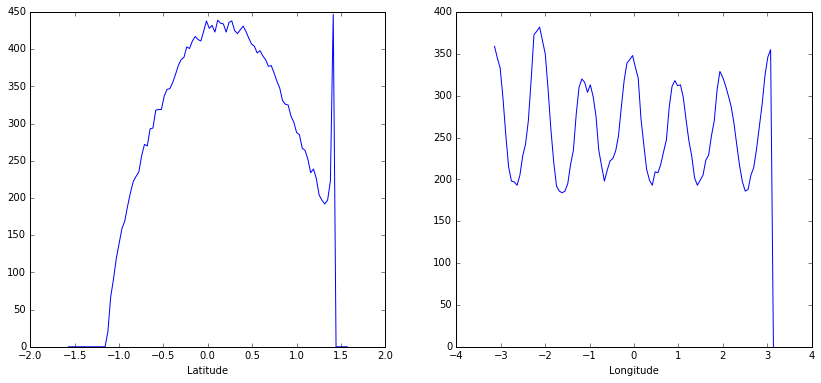

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(lat_grid, np.sum(bins, axis=1))
ax[0].set(xlabel='Latitude')
ax[1].plot(lon_grid, np.sum(bins, axis=0))
ax[1].set(xlabel='Longitude')

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


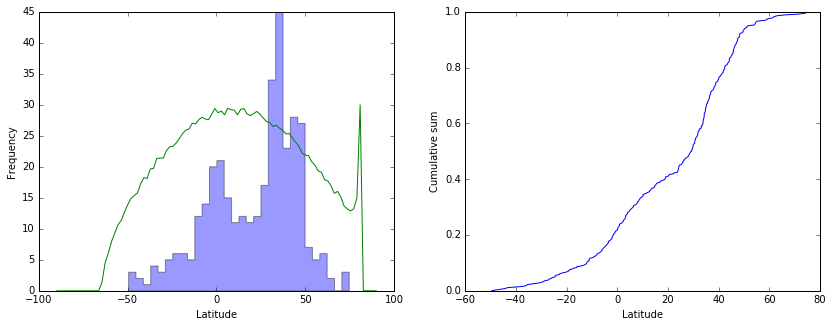

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lats = strong_lats[:int(0.5*len(strong_lats))]
second_half_strong_lats = strong_lats[-len(first_half_strong_lats):]

nbins = 30
ax[0].hist(np.degrees(strong_lats), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4)

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(strong_lats)))

sum_lats = np.sum(bins, axis=1)
ax[0].plot(np.degrees(lat_grid), sum_lats*30/sum_lats.max())
ax[0].legend(loc='upper left')
ax[0].set(xlabel='Latitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Latitude', ylabel='Cumulative sum'), 
         #title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

In [13]:
begin_kepler = Time('2009-05-06')
end_kepler = Time('2013-04-17')

n_time_bins = 10 # 
n_lat_bins = 30

time_bin_bounds = np.linspace(begin_kepler.jd, end_kepler.jd, n_time_bins+1)
lat_bin_bounds = np.linspace(-np.pi/2, np.pi/2, n_lat_bins+1)

lat_time_bins = np.zeros((n_lat_bins, n_time_bins))
for i in range(n_time_bins):
    min_time = time_bin_bounds[i]
    max_time = time_bin_bounds[i+1]

    lat_bins = np.zeros(n_lat_bins)
    for j in range(n_lat_bins):
        min_lat = lat_bin_bounds[j]
        max_lat = lat_bin_bounds[j+1]
        spots_in_bin = ((strong_lats_times > min_time) & (strong_lats_times < max_time) &
                        (strong_lats.ravel() < max_lat) & (strong_lats.ravel() > min_lat))
        lat_time_bins[j, i] = np.count_nonzero(spots_in_bin)

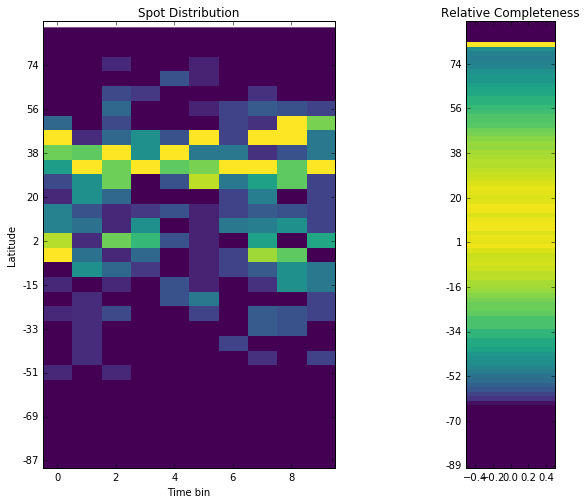

In [14]:
scaled_lat_time_bins = np.copy(lat_time_bins)

for i in range(scaled_lat_time_bins.shape[1]):
    scaled_lat_time_bins[:, i] = scaled_lat_time_bins[:, i]/np.max(scaled_lat_time_bins[:, i])

    
    
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].imshow(scaled_lat_time_bins, cmap=plt.cm.viridis, 
          origin='lower', interpolation='nearest')
ax[0].set_ylabel('Latitude')
ax[0].set_aspect(0.5)
skip = 3
lat_labels = np.degrees(0.5*(lat_bin_bounds[1:]+lat_bin_bounds[:-1])).astype(int)[::skip]

ax[0].set_yticks(range(len(lat_bin_bounds-1))[::skip])
ax[0].set_yticklabels(lat_labels)
ax[0].set_xlabel('Time bin')
ax[0].set_aspect(0.5)
ax[0].set_title('Spot Distribution')

skip = 10
ax[1].imshow(np.atleast_2d(sum_lats*30/sum_lats.max()).T, cmap=plt.cm.viridis, 
             origin='lower', interpolation='nearest')
ax[1].set_aspect(0.05)
lat_labels2 = np.degrees(0.5*(lat_grid[1:]+lat_grid[:-1])).astype(int)[::skip]
ax[1].set_yticks(range(len(lat_grid))[::skip])
ax[1].set_yticklabels(lat_labels2)
ax[1].set_title('Relative Completeness')

fig.subplots_adjust(wspace=-0.3)
plt.show()

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


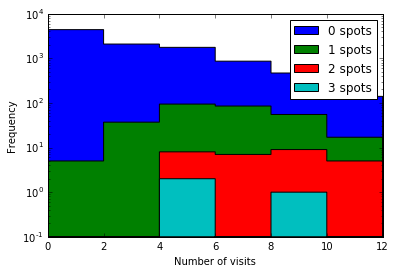

In [15]:
# plt.plot(spots_in_visit_bin.ravel(), bins.ravel(), '.')
# x = np.arange(spots_in_visit_bin.max())
# p = np.polyfit(spots_in_visit_bin.ravel(), bins.ravel(), 1)
# plt.plot(x, np.polyval(p, x))
# plt.show()

nbins = 6
visits_and_spots = np.zeros((nbins, spots_in_visit_bin.max()+1))
for i, n_spots_in_bin in enumerate(set(spots_in_visit_bin.ravel())):
    freq, edges = np.histogram(bins[spots_in_visit_bin == 
                                    n_spots_in_bin].ravel(),
                               nbins, range=(0, bins.max()))
    visits_and_spots[:, i] = freq
    plt.hist(bins[spots_in_visit_bin == n_spots_in_bin].ravel(),
             nbins, range=(0, bins.max()), log=True, 
             label="{0:d} spots".format(int(n_spots_in_bin)),
             histtype='stepfilled')
plt.xlabel('Number of visits')
plt.ylabel('Frequency')
plt.ylim([1e-1, 1e4])
plt.legend()

# plt.figure()
# plt.imshow(np.log(visits_and_spots), 
#            cmap=plt.cm.viridis,
#            interpolation='nearest',
#            origin='lower')
# plt.xlabel('Spots in spatial bin')
# plt.ylabel('Visits in spatial bin')

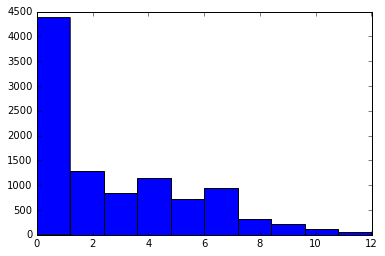

In [16]:
plt.hist(bins.ravel(), bins=10);

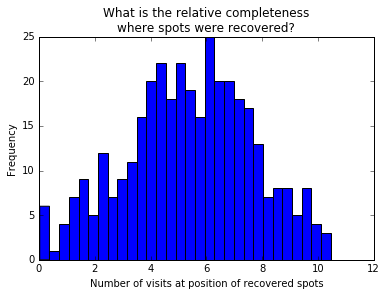

In [17]:
# Try interpolating over spatial completeness bins, then test correlation
# between visit density at the places where spots were detected

from scipy.interpolate import interp2d

interp = interp2d(lon_grid, lat_grid, bins)

# plt.imshow(interp(lon_grid, lat_grid), origin='lower')

spot_interps = [interp(lo, la)[0] for lo, la in zip(strong_lons.ravel(), strong_lats.ravel())]
plt.hist(spot_interps, bins=30)
plt.xlabel('Number of visits at position of recovered spots')
plt.ylabel('Frequency')
plt.title('What is the relative completeness\nwhere spots were recovered?');

# Which of these spots shouldn't be trusted? 

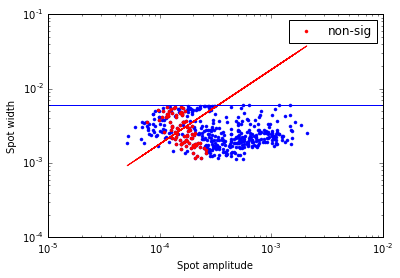

In [18]:
amplitudes = np.array([spot.amplitude.value 
                       for transit in transits 
                       for spot in transit.spots])
sigmas = np.array([spot.sigma.value 
                   for transit in transits 
                   for spot in transit.spots])
db = np.array([spot.delta_BIC
                   for transit in transits 
                   for spot in transit.spots])

#plt.loglog(amplitudes, sigmas, '.')
def spot_shape_boundary(amplitude):
    return 18*amplitude

plt.loglog(amplitudes, sigmas, '.')
plt.loglog(amplitudes[db < 10], sigmas[db < 10], 'r.', label='non-sig')
plt.plot(amplitudes, spot_shape_boundary(amplitudes), 'r')
plt.legend(numpoints=1)
plt.xlabel('Spot amplitude')
plt.ylabel('Spot width')
plt.axhline(6e-3)
# from sklearn.cluster import KMeans
# y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(np.vstack([amplitudes, sigmas]).T)

# fig, ax = plt.subplots()
# #ax.loglog(amplitudes, sigmas, '.', c=y_pred)
# for a, s, c in zip(amplitudes, sigmas, y_pred):
#     ax.loglog(a, s, '.', color='r' if c else 'b')
# ax.set_xlim([0.000, 0.003])

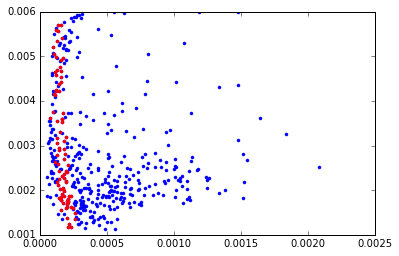

In [19]:
plt.plot(amplitudes, sigmas, '.')
plt.plot(amplitudes[db < 10], sigmas[db < 10], 'r.', label='non-sig')
#plt.plot(amplitudes, spot_shape_boundary(amplitudes), 'r')
#plt.hist(amplitudes, 10, log=True)
#plt.legend(numpoints=1)
#plt.xlabel('Spot amplitude')
#plt.ylabel('Spot width')

In [20]:

for transit in transits:
    for spot in transit.spots:
        short_and_wide = spot.sigma.value > 18*spot.amplitude.value
        spot.meta = dict(short_wide=int(short_and_wide))

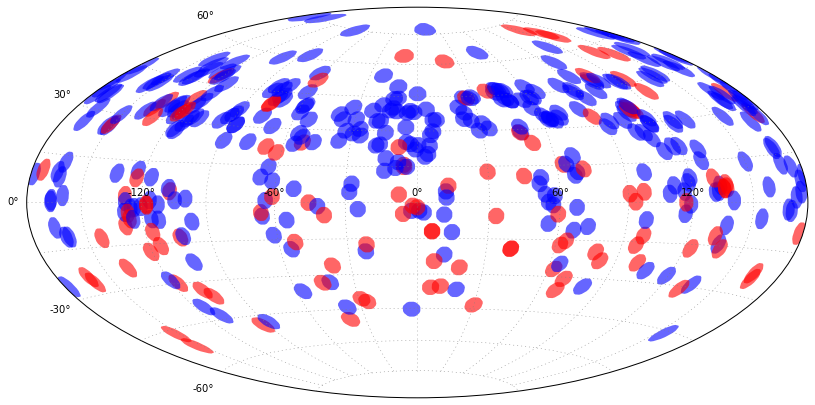

In [21]:
# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(111, projection=projection.lower())#, axisbg='black')

custom_grid(ax)

# all_spot_times = np.array([spot.t0.value for spot in transit.spots 
#                            for transit in transits])
all_spot_times = np.array([spot.t0.value for transit in transits
                           for spot in transit.spots])


radius = transit_params.rp  # from s=r*theta

cmap = plt.cm.viridis
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        alpha = 0.6
        #alpha = 0.5/sigma_prior(spot.sigma.value)
        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, linewidth=0,
                            alpha = alpha if alpha < 1 else 1,
                            color='r' if spot.meta['short_wide'] else 'b')
                            #color=cmap(tcolorscale(spot.t0.value)))

from matplotlib.ticker import FuncFormatter
from astropy.time import Time

#plot_color_gradients(fig, ax2)
fig.subplots_adjust(hspace=-0.55)